In [1]:
%load_ext autoreload
%autoreload 2

# Background

When building Large Language Model (LLM) applications, we strive to balance between achieving the highest response quality while adhering to a limited cost budget. Closed models like GPT-4 are renowned for their superior quality, but they can become prohibitively expensive, especially when handling a large volume of queries. On the other hand, Open Source Software (OSS) models are more cost-effective but may not deliver the same quality, particularly for complex or domain-specific queries.

A "smart router" addresses this challenge by processing user queries and deciding whether to route them to a closed LLM or an OSS LLM, depending on the query's complexity or domain. Here’s a schematic representation of a smart router:
![Smart Router](assets/router_schema.png)

Given a set of user queries, a smart router enables generating high-quality LLM responses while minimizing the overall cost.

# Approach

In this tutorial, we'll demonstrate how to train a smart router on the Anyscale platform. We make the following design choices:

1. **Model Choices**: We’ll use GPT-4 as an example of a closed LLM and Mixtral-8x7B as the OSS LLM, so our smart router will route between these two models.
2. **Response Quality Rating**: We'll quantify the quality of an LLM response on a scale of 1 to 5 stars, with higher scores indicating better quality. For simplicity, we'll assume that GPT-4 always achieves a 5-star rating, so it serves as a reference for Mixtral-8x7B.
3. **Smart Router Model**: We'll finetune a Llama3-8B model as our smart router and leverage Anyscale's powerful API. Our research (see our [arXiv paper](put link to arxiv paper)) shows that this model offers superior routing performance compared to smaller architectures.

More concretely, the objective of a smart router is to direct simple queries to Mixtral-8x7B, thereby maintaining high overall response quality (e.g., an average score of 4.8/5) while significantly reducing costs (e.g., by 50%).



# Table of Contents

### Steps to Train a Smart Router

1. [**Prepare labeled data**](#generate-labeled-data): We describe in this section how we generate synthetic labeled data to train the smart router model.

2. [**Finetune a router model**](#finetune-router-model)
TODO

1. [**Evaluate router model offline**](#evaluate-router-model-offline)
TODO



# Step 1: Prepare Labeled Data <a id="generate-labeled-data"></a>

Our smart router essentially functions as a binary classifier, deciding whether to route a query to GPT-4 or Mixtral-8x7B based on the query text. Initially, we considered labeled data in the format `(query, routing_label)`, where `routing_label` is 1 if the query should be routed to Mixtral-8x7B and 0 if it should be routed to GPT-4.

However, our early experiments revealed that *binary labels do not provide sufficient signal for training a robust router model*. Therefore, we adopted a different labeling approach using a *1-5 scoring system*, which reflects how well Mixtral-8x7B can effectively respond to the user's query. More specifically:

- **4-5**: Mixtral-8x7B produces a very strong answer, showing deep understanding, creativity, detailed insight, and high relevance.
- **3**: Mixtral-8x7B provides an adequate answer with moderate detail, relevance, and factual accuracy.
- **1-2**: Mixtral-8x7B struggles to produce a strong answer due to the question's difficulty, vagueness, or the model's limitations.

We use labeled samples in the format `(query, score_label)`. The `routing_label` can be derived from the `score_label` by setting a score threshold for quality, i.e. `routing_label = 1 if score_label >= 4 else 0`.

In the following, we will explain how we prepare our labeled dataset in detail.


## 1.1: Query Dataset

We want our smart router to be effective in open-ended chat domains. So, our first step is to collect a set of generic queries from the [Nectar dataset](https://huggingface.co/datasets/berkeley-nest/Nectar). We chose the Nectar dataset for two reasons: it combines queries from many different domains, including open-ended chat, and it has responses from many models, including over 191K responses from GPT-4.

In [2]:
from utils import load_and_display_nectar

nectar_df = load_and_display_nectar()

,prompt,answers,turns,num_responses,source,good_natured
0,\n\nHuman: 0.002 = 1000 \n1 = x?\n\nAssistant:,"[{'answer': 'To find the value of x, we can set up a proportion using the given information: 0.002/1000 = 1/x To solve for x, we can cross multiply: 0.002 * x = 1000 * 1 0.002x = 1000 Dividing both sides by 0.002: x = 1000 / 0.002 x = 500,000 Therefore, 1 is equal to 500,000 in this proportion.', 'model': 'gpt-3.5-turbo', 'rank': 1.0}, {'answer': 'To solve for x in this equation, you can use cross-multiplication. Here's how: 0.002 / 1 = 1000 / x Cross-multiplication gives: 0.002 * x = 1000 To solve for x, divide both sides by 0.002: x = 1000 / 0.002 So, x equals 500,000.', 'model': 'gpt-4-0613', 'rank': 2.0}, {'answer': 'This looks like a proportion. To solve for x, you can set up a proportion equation: 0.002 / 1 = 1000 / x Now, cross-multiply: 0.002 \* x = 1 \* 1000 Then, solve for x: 0.002x = 1000 x = 1000 / 0.002 x = 500,000', 'model': 'gpt-3.5-turbo', 'rank': 3.0}, {'answer': 'If 0.002 equals 1000, then 1 would equal 500,000.', 'model': 'gpt-4', 'rank': 4.0}, {'answer': 'I apologize, but the equation you provided is not correct. 0.002 is equal to 0.002, not 1000. 1 is equal to x, not a number. Can you please provide a correct equation or problem for me to solve?', 'model': 'llama-2-7b-chat', 'rank': 5.0}, {'answer': '0.001 = x', 'model': 'gpt-3.5-turbo-instruct', 'rank': 6.0}, {'answer': 'It seems like you are asking for the value of x in the equation x = 1/0.002. To solve this equation, you can divide both sides by 0.002 to get: x = 1/0.002 x = 500 Therefore, x = 500.', 'model': 'mistral-7b-instruct-v0.1', 'rank': 7.0}]",1,7,[sharegpt],True


Number of queries with GPT-4 responses: 191487


## 1.2 Data Preprocessing

We will use a subset of the Nectar data that includes responses from GPT-4, as these will be used to generate scores (as seen below). We will process this data by focusing on single-turn conversations, filtering for good-natured interactions, and cleaning up the prompts and responses to maintain high quality. Additionally, we will sample a small subset from the dataset for the purpose of this tutorial; however, you can skip sampling to work with the full dataset.

In [3]:
from utils import preprocess_nectar

nectar_gpt4_df = preprocess_nectar(
    nectar_df, model="gpt-4", response_column="gpt4_response"
)

# Sample a small subset from the dataset for the purpose of this tutorial
N_SUBSET = 30
dataset_df = nectar_gpt4_df.sample(N_SUBSET, random_state=42)

## 1.3 Data Labeling

We don't have human labels for scores, so we will use the [LLM-as-a-Judge approach](https://arxiv.org/abs/2306.05685). GPT-4 will act as an evaluator, reviewing the query and Mixtral's response to provide a score from 1-5. As shown in the paper, the most robust way to get labels is by providing a reference answer for comparison. Here, GPT-4's own response serves as the reference, and Mixtral's response is evaluated against it.

There are two main steps in this process:
1. **Generate Mixtral-8x7B responses for all queries**: We will use an online batch-inference method utilizing Ray and Anyscale endpoints.
2. **Generate LLM-as-a-Judge labels**: We will ask GPT-4 to evaluate the Mixtral responses against its own reference answers and provide a score from 1-5.

### Generate Mixtral-8x7B Responses

In [4]:
import yaml
from online_inference import generate_mixtral_responses

# store ANYSCALE_API_KEY: "your_api_key_here" in keys.yaml
with open("keys.yaml") as config_file:
    keys = yaml.safe_load(config_file)
    anyscale_api_key = keys["ANYSCALE_API_KEY"]

dataset_df = generate_mixtral_responses(
    dataset_df, anyscale_api_key, response_column="mixtral_response"
)

Starting batch inference on 30 queries...


2024-06-20 16:49:48,001	INFO worker.py:1568 -- Connecting to existing Ray cluster at address: 10.0.0.22:6379...
2024-06-20 16:49:48,009	INFO worker.py:1744 -- Connected to Ray cluster. View the dashboard at https://session-3mbbhc76us4jta3ixstn8kjsxy.i.anyscaleuserdata.com 
2024-06-20 16:49:48,016	INFO packaging.py:358 -- Pushing file package 'gcs://_ray_pkg_308c76ce861d8c0b8f13e9b003839287080328e0.zip' (0.30MiB) to Ray cluster...
2024-06-20 16:49:48,018	INFO packaging.py:371 -- Successfully pushed file package 'gcs://_ray_pkg_308c76ce861d8c0b8f13e9b003839287080328e0.zip'.


# queries un-processed: 29, in-progress: 1, ready: 0
# queries un-processed: 28, in-progress: 2, ready: 0
# queries un-processed: 27, in-progress: 3, ready: 0
# queries un-processed: 26, in-progress: 4, ready: 0
# queries un-processed: 25, in-progress: 5, ready: 0
# queries un-processed: 24, in-progress: 6, ready: 0
# queries un-processed: 23, in-progress: 6, ready: 1
# queries un-processed: 22, in-progress: 7, ready: 0
# queries un-processed: 21, in-progress: 8, ready: 0
# queries un-processed: 20, in-progress: 9, ready: 0
# queries un-processed: 19, in-progress: 10, ready: 0
# queries un-processed: 18, in-progress: 11, ready: 0
# queries un-processed: 17, in-progress: 12, ready: 0
# queries un-processed: 16, in-progress: 12, ready: 1
# queries un-processed: 15, in-progress: 13, ready: 0
# queries un-processed: 14, in-progress: 14, ready: 0
# queries un-processed: 13, in-progress: 14, ready: 1
# queries un-processed: 12, in-progress: 15, ready: 0
# queries un-processed: 11, in-progres

,prompt,source,gpt4_response,mixtral_response
6062,"Based on the features mentioned, which hotel d...",[evol_instruct],"Based on the features mentioned, Hotel A seems...","Based on the information you've provided, the..."
113830,Provide step-by-step instructions on how to cr...,[ultrachat],"Sure, here's a simple step-by-step guide on ho...","Sure, I'd be happy to help you make a homemad..."
138869,What are the 10 largest cities in the US by po...,[lmsys-chat-1m],"As of the most recent data available, the 10 l...","Sure, I'd be happy to help with that! Here ar..."
169249,Write a comparison essay of at least 500 words...,[ultrachat],Title: A Comparative Analysis of Driving a Car...,Title: The Great Debate: Driving a Car vs. Ri...
116934,"Q: You are provided with an ""Event"", ""Intent"" ...",[flan_v2_niv2],PersonX might feel satisfied or content using ...,PersonX probably feels comfortable and focuse...


Saving results to assets/test_dataset.jsonl.


(autoscaler +30m27s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.


### Generate GPT-4-as-a-judge scores 

Let's first take a look at an example query we will send to GPT-4 for judgement

In [10]:
from utils import inspect_llm_judge_queries

inspect_llm_judge_queries(dataset_df)

[Instruction]
Evaluate the AI assistant's proficiency in answering the user question displayed below. Your evaluation should consider factors such as the helpfulness, relevance, adherence to real-world facts, depth, creativity, and level of detail of the response. You will be given a reference answer which is considered of high quality. Your assessment will have two lines: First line has a rating on a scale of 1 to 5 with a higher rating representing higher response quality. Follow strictly this format: "[[rating]]", for example: "[[3]]". Second line contains a short explanation of your rating.

[Question]
Q: You are provided with an "Event", "Intent" related to PersonX. Guess a reaction/reaction of PersonX about the given event and their intention.
Event:PersonX uses ___ in class. Intent: 1) to use his prefered writing implement
A:

[Reference Answer]
PersonX might feel satisfied or content using their preferred writing implement in class, as it aligns with their intention to utilize 

Now, we apply a similar online batch-inference method to generate our labels.

In [11]:
import yaml
from online_inference import generate_llm_judge_labels

# store OPENAI_API_KEY: "your_api_key_here" in keys.yaml
with open("keys.yaml") as config_file:
    keys = yaml.safe_load(config_file)
    openai_api_key = keys["OPENAI_API_KEY"]

dataset_df = generate_llm_judge_labels(dataset_df, openai_api_key)

Starting batch inference on 30 queries...
# queries un-processed: 29, in-progress: 1, ready: 0
# queries un-processed: 28, in-progress: 2, ready: 0
# queries un-processed: 27, in-progress: 3, ready: 0
# queries un-processed: 26, in-progress: 4, ready: 0
# queries un-processed: 25, in-progress: 5, ready: 0
# queries un-processed: 24, in-progress: 5, ready: 1
# queries un-processed: 23, in-progress: 6, ready: 0
# queries un-processed: 22, in-progress: 7, ready: 0
# queries un-processed: 21, in-progress: 7, ready: 1
# queries un-processed: 20, in-progress: 8, ready: 0
# queries un-processed: 19, in-progress: 9, ready: 0
# queries un-processed: 18, in-progress: 10, ready: 0
# queries un-processed: 18, in-progress: 9, ready: 1
# queries un-processed: 17, in-progress: 9, ready: 1
# queries un-processed: 16, in-progress: 9, ready: 1
# queries un-processed: 15, in-progress: 10, ready: 0
# queries un-processed: 15, in-progress: 9, ready: 1
# queries un-processed: 14, in-progress: 9, ready: 1
# 

,prompt,source,gpt4_response,mixtral_response,mixtral_score
6062,"Based on the features mentioned, which hotel d...",[evol_instruct],"Based on the features mentioned, Hotel A seems...","Based on the information you've provided, the...",5
113830,Provide step-by-step instructions on how to cr...,[ultrachat],"Sure, here's a simple step-by-step guide on ho...","Sure, I'd be happy to help you make a homemad...",3
138869,What are the 10 largest cities in the US by po...,[lmsys-chat-1m],"As of the most recent data available, the 10 l...","Sure, I'd be happy to help with that! Here ar...",5
169249,Write a comparison essay of at least 500 words...,[ultrachat],Title: A Comparative Analysis of Driving a Car...,Title: The Great Debate: Driving a Car vs. Ri...,4
116934,"Q: You are provided with an ""Event"", ""Intent"" ...",[flan_v2_niv2],PersonX might feel satisfied or content using ...,PersonX probably feels comfortable and focuse...,5


Saving results to assets/labeled_test_dataset.jsonl.


### Full Dataset
We have previously generated the full labeled datasets, created a train and validation splits, and published them as a public huggingface dataset `outellm/gpt4_dataset`. Let's load the dataset and explore the score distribution.


Train size: 109101
Validation size: 10000


,prompt,source,gpt4_response,mixtral_response,mixtral_score
0,"I'll give you a review, can you extract the fo...",[lmsys-chat-1m],"Sure, here's the analysis of the review:\n\n1....",Food aspects and opinion words:\n\n1. Made to ...,4
1,"Answer the following question: Claim: ""Joker m...",[flan_v2_cot],The answer is no.\nChain of thoughts: Stan Lee...,The answer is no.\n\nChain of thoughts: While ...,5
2,TASK DEFINITION: In this task you will be give...,[flan_v2_niv2],ZdoublexpropheciesS,"ZdoublexpropheciesS\n\nIn this task, you are a...",5
3,"Detailed Instructions: In this task, you need ...",[flan_v2_niv2],Yes,"No, 'station' is not the longest word in the s...",5
4,A guy pick up a woman Then he puts her down Ex...,[sharegpt],This phrase could be interpreted as a joke bec...,This joke is a play on words and relies on the...,5


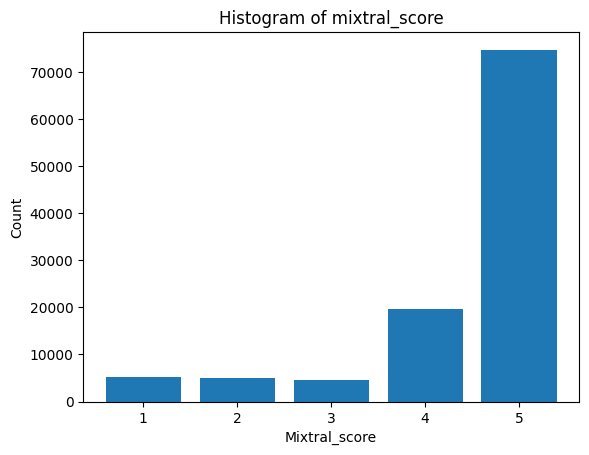

In [2]:
from datasets import load_dataset
from utils import visualize_label_distribution

full_dataset_df = load_dataset("routellm/gpt4_dataset")
train_df = full_dataset_df["train"].to_pandas()
valid_df = full_dataset_df["validation"].to_pandas()

print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(valid_df)}")
display(train_df.head())
visualize_label_distribution(train_df, key="mixtral_score")


Higher counts for 4-5 scores indicate that Mixtral-8x7B consistently produces high-quality responses, demonstrating its competitive performance compared to the June 2023 version of GPT-4, whose responses are logged in the Nectar dataset.

Let us assume that if the score is >= 4, we will route to the OSS model (indicating the response quality is good enough); otherwise, we will route to the closed model. Under this assumption, the data distribution looks like this:


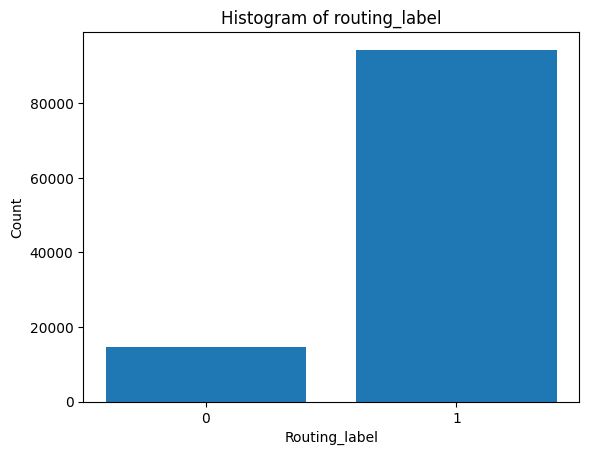

In [3]:
train_df["routing_label"] = train_df["mixtral_score"].apply(
    lambda x: 1 if x >= 4 else 0
)
visualize_label_distribution(train_df, key="routing_label")

# Step 2: Finetune a router model <a id="finetune-router-model"></a>

In this section, we will explain how to finetune an LLM as a smart router. While our data contains `gpt4_response` and `mixtral_response`, we will only use the pair (`query`, `mixtral_score`) for training. The goal is for the smart router to rely solely on the query text to determine which model to route to. Our approach is straightforward: we train a 5-way classifier to predict the `mixtral_score` from the `query`. At inference time, we will route to Mixtral if our router predicts a high score (i.e., 4-5) and to GPT-4 otherwise.


## 2.1 Data Preparation
We will discuss a few preprocessing steps to prepare the data for finetuning an LLM to be a smart router.

### Task Instructions
We use the instruction-following framework to finetune an LLM as a smart router. The task instructions guide the model to predict the score label for a given query. They ensure the model understands the evaluation criteria and can accurately assess the query's complexity and expected response quality.

In [12]:
from utils import inspect_instructions
inspect_instructions(train_df)

[Instruction]
Based on the question provided below, predict the score an expert evaluator would give to an AI assistant's response, considering its helpfulness, relevance, adherence to facts, depth, creativity, and detail. Your prediction should infer the level of proficiency needed to address the question effectively. Use a scale from 1 to 5, where a higher score indicates a higher anticipated quality of response. Provide your prediction as: "[[predicted rating]]".

Score criteria:
- **4-5**: The AI assistant can produce a very strong answer, showing deep understanding, creativity, detailed insight, and high relevance.
- **3**: The AI assistant can provide an adequate answer with moderate detail, relevance, and factual accuracy.
- **1-2**: The AI assistant will struggle to produce a strong answer due to the question's difficulty, vagueness, or the assistant's limitations.

[Question]
{question}

Prediction:


### API Data Format

To finetune the model, we must format the data to be compatible with [Anyscale's finetuning API](https://docs.anyscale.com/endpoints/fine-tuning/dataset-prep).


In [13]:
from utils import prepare_ft_messages

train_df["messages"] = prepare_ft_messages(train_df, 'mixtral_score')

# here's what the API data format looks like:
display(train_df["messages"].iloc[0])

[{'role': 'system',
  'content': '[Instruction]\nBased on the question provided below, predict the score an expert evaluator would give to an AI assistant\'s response, considering its helpfulness, relevance, adherence to facts, depth, creativity, and detail. Your prediction should infer the level of proficiency needed to address the question effectively. Use a scale from 1 to 5, where a higher score indicates a higher anticipated quality of response. Provide your prediction as: "[[predicted rating]]".\n\nScore criteria:\n- **4-5**: The AI assistant can produce a very strong answer, showing deep understanding, creativity, detailed insight, and high relevance.\n- **3**: The AI assistant can provide an adequate answer with moderate detail, relevance, and factual accuracy.\n- **1-2**: The AI assistant will struggle to produce a strong answer due to the question\'s difficulty, vagueness, or the assistant\'s limitations.\n'},
 {'role': 'user',
  'content': "[Question]\nI'll give you a review

### Label Rebalancing

For classification tasks, it's recommended to train on label-balanced datasets to ensure models are not biased to a specific label. We will balance the dataset based on `routing_label`, as this is the label of primary interest.


In [4]:
from utils import balance_dataset

balanced_train_df = balance_dataset(train_df, key="routing_label")
print(f"Train size: {len(balanced_train_df)}")

Train size: 29504


### Subsample and Store Data

To expedite the time to run this tutorial, we will subsample 1,000 examples for training. We'll store the data in JSONL format to prepare for launching the finetuning job in the next section.

In [5]:
n_sample = 1000
output_file = "/mnt/user_storage/train_data_sample.jsonl"

subsampled_df = balanced_train_df.sample(n=n_sample, random_state=42)
subsampled_df.to_json(output_file, orient='records', lines=True)

## 2.2 Fine-tune with Anyscale API
REWRITE: We will run a fine-tuning with Anyscale's LLM finetuning API workload as an isolated job (similar to this example https://github.com/anyscale/e2e-llm-workflows?tab=readme-ov-file#fine-tuning-1). 



In [9]:
!cat assets/ft_config_debug.yaml

model_id: meta-llama/Meta-Llama-3-8B
train_path: s3://air-example-data/llmforge-test-data/classifier/ft_train_balanced_1k.jsonl
valid_path: s3://air-example-data/llmforge-test-data/classifier/ft_train_balanced_1k.jsonl
context_length: 1024
num_devices: 4
num_epochs: 5
checkpoint_every_n_epochs: 5
train_batch_size_per_device: 8
eval_batch_size_per_device: 8
lr_scheduler_type: constant
learning_rate: 1e-5
num_checkpoints_to_keep: 1
no_gradient_checkpoint: False
output_dir: /mnt/local_storage
deepspeed:
  config_path: config_files/deepspeed/zero_3.json
flash_attention_2: true
classifier_config:
  label_tokens:
      - "[[1]]"
      - "[[2]]"
      - "[[3]]"
      - "[[4]]"
      - "[[5]]"
  eval_metrics:
      - "prauc"

#  Batch inference with router model

#  Evaluate router performance

## Baselines
1. Random

In [ ]:
from collections import OrderedDict

router_predictions = OrderedDict()

In [ ]:
import numpy as np

rng = np.random.RandomState(123)
router_predictions["Random"] = rng.uniform(0, 1, len(validation_df))

In [ ]:
from evaluation_metrics import plot_quality_cost_curve

oss_model_scores = validation_df["label"].to_numpy()
closed_model_scores = np.ones(len(validation_df["label"])) * 5.0

plot_quality_cost_curve(oss_model_scores, closed_model_scores, router_predictions)